绿色环保车牌

In [1]:
import os
import os.path
import shutil
import cv2
import math
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
def imshow(img):
    s=img.shape
    if len(s)>2:
        b,g,r=cv2.split(img)
        img=cv2.merge([r,g,b])
    else:
        img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [22]:
#PICFILE='/home/wang/git/nppic/214.jpg'
#PICFILE='/home/wang/git/nppic/mmexport1493368628110.jpg'  #比亚迪电动车绿色车牌
#PICFILE='/home/wang/git/anpr/data/mmexport1494310135346.jpg'  #新能源大巴
PICFILE='/home/wang/git/anpr/data/2017-05-10_105333.png'     #新能源大巴的截取

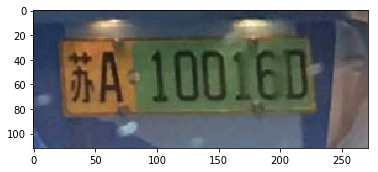

In [23]:
img = cv2.imread(PICFILE)
imshow(img)

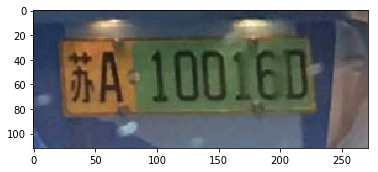

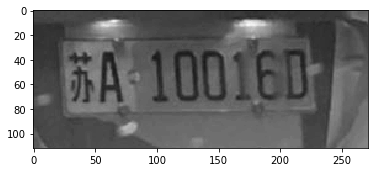

In [24]:
GaussianBlurSize=5

#img=cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0]/2)))
imshow(img)

#高斯模糊20170221_141654
#imggauss=cv2.GaussianBlur(img,(7,3),GaussianBlurSize)
#imshow(imggauss)
#cv2.imwrite('/home/wang/git/nppic/tt.jpg',imggauss)
#灰度化
imggray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#imggray=cv2.cvtColor(imggauss,cv2.COLOR_BGR2GRAY)
#print imggray.shape
imshow(imggray)

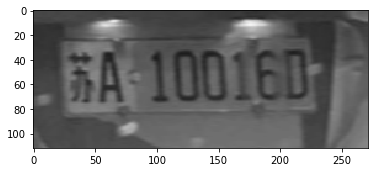

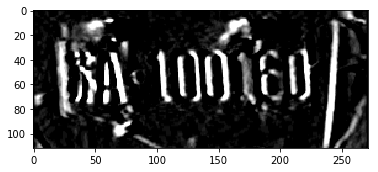

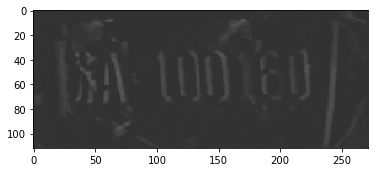

In [25]:
#imggray=cv2.equalizeHist(imggray)  #直方图均衡化，新增
#imshow(imggray)
imggauss=cv2.GaussianBlur(imggray,(5,1),GaussianBlurSize)
imshow(imggauss)
imgscharr=cv2.Scharr(imggauss,ddepth=-1,dx=1,dy=0)
imgsobel=cv2.Sobel(imggauss,ddepth=-1,dx=1,dy=0,ksize=1)  #dxdy前者1后者0，代表仅做水平方向求导不做垂直方向求导
#print imgsobel.shape
imshow(imgscharr)
imgsobel=imgsobel+50
imshow(imgsobel)
#cv2.imwrite('/home/wang/git/nppic/tt.jpg',imgsobel)


(112, 272)


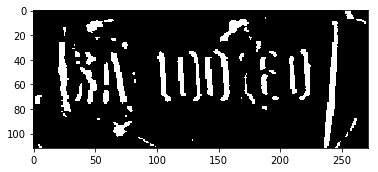

In [26]:
#二值化
_,imgthreshold  = cv2.threshold(imgsobel, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY) #二值化
print imgthreshold.shape
imshow(imgthreshold)

(112, 272)
(112, 272)


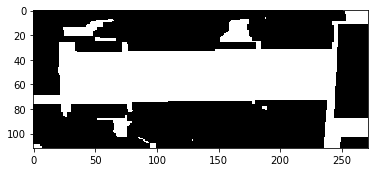

True

In [28]:
#闭操作
print imgthreshold.shape
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(35,5)) #(7,3)闭操作，先膨胀再腐蚀
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(35,5)) #(7,3)闭操作，先膨胀再腐蚀
imgclose=cv2.morphologyEx(imgthreshold, cv2.MORPH_CLOSE, kernel)
##eroded = cv2.erode(imgt,kernel)
#imclose = cv2.dilate(imgthreshold,kernel)
print imgclose.shape
imshow(imgclose)
cv2.imwrite('/home/wang/git/nppic/tt.jpg',imgclose)


In [29]:
#轮廓
(contours, _) = cv2.findContours(imgclose.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

1
[(1, 1, 270, 110)]


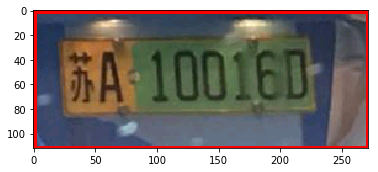

In [34]:
#对轮廓求最小外接矩形，然后验证，不满足条件的淘汰
imgc=imgclose
con=sorted(contours,key=cv2.contourArea,reverse=True)            
#con=contours
ret=[]
for i,c in enumerate(con):
    x,y,w,h=cv2.boundingRect(c)
    if w <125:
        continue
    #if w < 200 or w > 500:
    #    continue
    #ratio=w//h
    #if ratio < 3:
    #    continue
    #if w< 400 or h < 150:
    #    continue
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
    ret.append((x,y,w,h))
print len(ret)
print ret
imshow(img)
#角度判断与旋转
#暂无

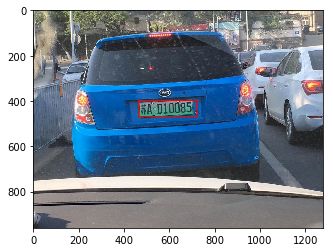

In [63]:
#绘制
imgrect = img.copy()
for i,r in enumerate(ret):
    x,y,w,h=r
    cv2.rectangle(imgrect,(x,y),(x+w,y+h),(0,0,255),4)
imshow(imgrect)    
#cv2.imwrite('/home/wang/git/nppic/tt.jpg',imgrect)

/home/wang/git/nppic/0.jpg


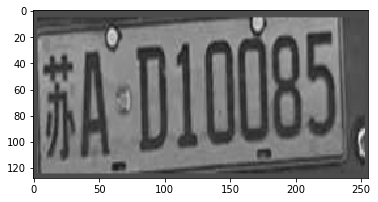

In [64]:
#截取
npjpg=[] #原图
detect=np.ndarray((len(ret),128,256),np.uint8) #检测的图
for i,(x,y,w,h) in enumerate(ret):
    imgr=imgrect[y:y+h,x:x+w]
    npjpg.append(imgr.copy())#imggray=cv2.equalizeHist(imggray)  #直方图均衡化，新增
#imshow(imggray)
imggauss=cv2.GaussianBlur(imggray,(5,1),GaussianBlurSize)
imshow(imggauss)
imgscharr=cv2.Scharr(imggauss,ddepth=-1,dx=1,dy=0)
imgsobel=cv2.Sobel(imggauss,ddepth=-1,dx=1,dy=0,ksize=1)  #dxdy前者1后者0，代表仅做水平方向求导不做垂直方向求导
#print imgsobel.shape
imshow(imgscharr)
imgsobel=imgsobel+50
imshow(imgsobel)
#cv2.imwrite('/home/wang/git/nppic/tt.jpg',imgsobel)
    imgray=cv2.cvtColor(imgr,cv2.COLOR_BGR2GRAY)
    imgray=cv2.resize(imgray,(256,128))
    detect[i]=imgray
    fname='/home/wang/git/nppic/{}.jpg'.format(i*100)
    print fname
    cv2.imwrite(fname,imgr)
imshow(detect[0])

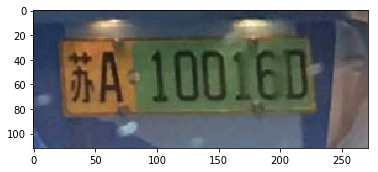

In [35]:
#字符切割
CHARFILE='/home/wang/git/nppic/0.jpg'
CHARFILE='/home/wang/git/anpr/data/2017-05-10_105333.png'
imgchar=cv2.imread(CHARFILE)
#imgchar=cv2.resize(charimg,(500,120))
imshow(imgchar)

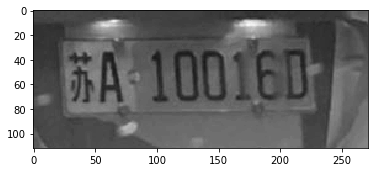

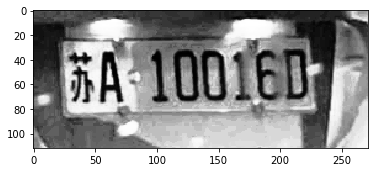

In [52]:
gray_img = cv2.cvtColor(imgchar.copy(),cv2.COLOR_BGR2GRAY)  #灰度
imshow(gray_img)
gray_img =cv2.equalizeHist(gray_img)  #直方图均衡化，新增
imshow(gray_img)

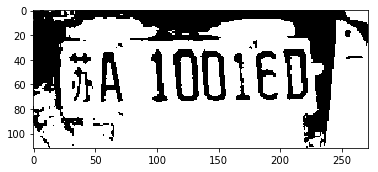

In [53]:
#_,threshold_img  = cv2.threshold(gray_img, 100, 255, cv2.THRESH_BINARY) #二值化
_,threshold_img  = cv2.threshold(gray_img, 80, 255, cv2.THRESH_BINARY) #二值化
imshow(threshold_img)

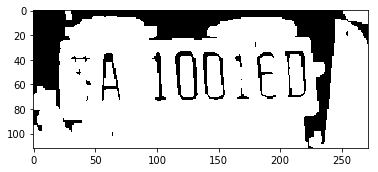

In [54]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)) #闭操作
eroded = cv2.erode(threshold_img,kernel)
dilated = cv2.dilate(eroded,kernel)
dilated = cv2.dilate(dilated,kernel)
imshow(dilated)

In [55]:
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)) #闭操作
#dialated=threshold_img

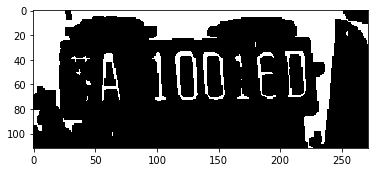

In [56]:
threshold_img=255-dilated
imshow(threshold_img)

In [58]:
(contours,_) = cv2.findContours(threshold_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
con=sorted(contours,key=cv2.contourArea,reverse=True)            
ret=[]
#w:500 h:124
for i,c in enumerate(con):
    x,y,w,h=cv2.boundingRect(c)
    ratio=float(h)/float(w)
    #if ratio<1.3 or ratio> 5:
    #    continue
    if h < 30:
        continue
    if w > 50:
        continue
    ret.append((x,y,w,h))
    print x,y,w,h
print len(ret)

115 33 19 40
138 34 18 39
205 33 17 38
56 35 15 39
97 34 11 40
182 34 15 38
6


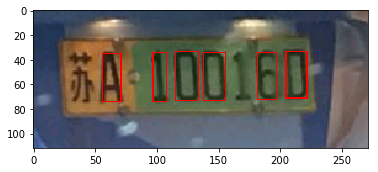

[(115, 33, 19, 40), (138, 34, 18, 39), (205, 33, 17, 38), (56, 35, 15, 39), (97, 34, 11, 40), (182, 34, 15, 38)]


In [59]:
#绘制
imgrect = imgchar.copy()
chars=sorted(ret)  ##根据x值进行排序
chars
for i,r in enumerate(chars):
    x,y,w,h=r
    cv2.rectangle(imgrect,(x,y),(x+w,y+h),(0,0,255),1)
imshow(imgrect)    
print ret

In [60]:
#len(ret) == 6
chardatas=np.ndarray((len(chars),1,28,28),np.uint8)
#以二值图像作为复制源
imgcut=threshold_img.copy()
for i,r in enumerate(chars):
    x,y,w,h=r
    print x,y,w,h
    chari=imgcut[y-3:y+h+3,x-3:x+w+3]  #切割
    #处理字母I
    canvas=np.zeros((28,28),np.uint8)    
    if (h//w) > 5:
        wi=int(w*28/h)
        chari=cv2.resize(chari.copy(),(wi,28))
        offset=int((28-wi)/2)
        print offset,wi,chari.shape
        canvas[:,offset:offset+wi]=chari
    else:    
        #chari=cv2.resize(chari.copy(),(18,28))    
        chari=cv2.resize(chari.copy(),(16,28))    
        canvas[:,6:22]=chari
    chardatas[i][0]=canvas
    fname='/home/wang/git/nppic/char-{}.bmp'.format(i)
    cv2.imwrite(fname,canvas)

56 35 15 39
97 34 11 40
115 33 19 40
138 34 18 39
182 34 15 38
205 33 17 38


In [61]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, 34)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))                              #28*28
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) #12*12
        x = x.view(-1, 4*4*20)                                                                #8*8
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x) 

In [62]:
#classes,class_to_idx=find_classes('/home/wang/git/nppic/ann/train')
#print class_to_idx
DIGITS='0123456789'
LETTER='ABCDEFGHJKLMNPQRSTUVWXYZ'
CHAR=DIGITS+LETTER
CHARCLASSES=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','J','K','L','M','N','P','Q','R','S','T','U','V','W','X','Y','Z']

In [63]:
net=Net()
net.load_state_dict(torch.load('/home/wang/git/anpr/coder.net.weight'))

In [64]:
chardatas=np.array(chardatas,np.float)
charimgdata=torch.FloatTensor(chardatas)
outputs = net(Variable(charimgdata))
_, predicted = torch.max(outputs.data, 1)
predicted


 10
  1
  0
  0
 14
  0
[torch.LongTensor of size 6x1]

In [65]:
pred=predicted.numpy()
n=''
for i,c in enumerate(pred):
    idx=int(c[0])
    n+=CHARCLASSES[idx]
print n

A100E0
